In [75]:
%matplotlib inline

import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt # standard Python plotting library
import numpy as np  # fundamental package for scientific computing, handles arrays and math
import scipy.signal
from scipy.signal import find_peaks, peak_prominences
import scipy.stats as stats
from scipy.stats import zscore
from pathlib import Path
import tdt # import the tdt library
import seaborn as sns
from matplotlib import rcParams
import os
import numpy as np
import glob
from scipy.signal import find_peaks, peak_prominences, peak_widths
import copy

In [116]:
isosbestic = '_415A'
dopa='_465A'
CHANNEL = 1
TRANGE       = [-5, 10]
BASELINE_PER = [-5, -0]
event_type = 'RNP_'
het_path = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\Progressive ratio day 2 tanks\het/*" # path to het folder remember /*
wt_path = r"C:\Users\User\Tischfield_Lab\Fiber_Photo\Sample_Tank\Progressive ratio day 2 tanks\wt/*"
def read_files(path): 
    blockpath = path
    data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)
    data = tdt.epoc_filter(data, event_type, t=TRANGE)  #filters the chosen epocs (RNP_) and time set around those epocs
    # More examples of list comprehensions
    min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
    min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
    data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
    data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    for lst in data['streams'][isosbestic].filtered: 
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F415.append(small_lst)

    for lst in data['streams'][dopa].filtered: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)

    #Create a mean signal, standard error of signal, and DC offset
    meanF415 = np.mean(F415, axis=0)
    stdF415 = np.std(F415, axis=0)/np.sqrt(len(data['streams'][isosbestic].filtered))
    dcF415 = np.mean(meanF415)
    meanF465 = np.mean(F465, axis=0)
    stdF465 = np.std(F465, axis=0)/np.sqrt(len(data['streams'][dopa].filtered))
    dcF465 = np.mean(meanF465)
    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F415, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    # Getting the z-score and standard error
    zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(ts2)<BASELINE_PER[1]) & (np.array(ts2)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        zall.append((dF - zb)/zsd)
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    #ts1 = ts2 since iso and dopamine are recorded simulteanosuly (I can't spell)
    
    zerror = np.std(zall, axis=0)

    return zall, ts1, ts2, zerror



In [117]:
h_dict = {}
w_dict = {}

for file in glob.glob(het_path):
    z_ind = read_files(file)
    h_ts1 = z_ind[1]
    ts2 = z_ind[2]
    h_dict[os.path.basename(file)]={"z-score": z_ind[0]}
    
for file in glob.glob(wt_path):
    z_ind = read_files(file)
    w_ts1 = z_ind[1]
    w_dict[os.path.basename(file)]={"z-score": z_ind[0]}


read from t=0s to t=3599.19s
read from t=0s to t=3599.09s
read from t=0s to t=3599.11s
read from t=0s to t=3599.14s
read from t=0s to t=3599.09s
read from t=0s to t=3599.11s
read from t=0s to t=3599.22s
read from t=0s to t=3599.25s
read from t=0s to t=3599.11s
read from t=0s to t=3599.1s
read from t=0s to t=3599.08s
read from t=0s to t=3599.23s
read from t=0s to t=3599.06s
read from t=0s to t=3599.09s
read from t=0s to t=3599.09s
read from t=0s to t=3599.2s
read from t=0s to t=3599.2s


In [118]:
trimmed_ts = []
trimmed_idx = []
for i in range(len(ts2)):
    if ts2[i]>=0 and ts2[i]<=2:
        trimmed_ts.append(ts2[i])
        trimmed_idx.append(i)
for key in h_dict.keys():
    trimmed_z_key = []    
    for i in range(len(h_dict[key]['z-score'])):
        trimmed_z = []
        for j in range(len(h_dict[key]['z-score'][i])):
            if j in trimmed_idx:
                trimmed_z.append(h_dict[key]['z-score'][i][j])
        trimmed_z_key.append(trimmed_z)
    h_dict[key]['trimmed_z-score']=trimmed_z_key

for key in w_dict.keys():
    trimmed_z_key = []    
    for i in range(len(w_dict[key]['z-score'])):
        trimmed_z = []
        for j in range(len(w_dict[key]['z-score'][i])):
            if j in trimmed_idx:
                trimmed_z.append(w_dict[key]['z-score'][i][j])
        trimmed_z_key.append(trimmed_z)
    w_dict[key]['trimmed_z-score']=trimmed_z_key

In [119]:
for key in h_dict.keys():
    hpeak_key = []
    hwidth_key = []
    for i in range(len(h_dict[key]['trimmed_z-score'])):
        hpeaks = find_peaks(h_dict[key]['trimmed_z-score'][i], prominence = 1)
        # if len(hpeaks[0]!=0):
        hwidths = peak_widths(h_dict[key]['trimmed_z-score'][i], hpeaks[0])
        hpeak_key.append(hpeaks[0])
        hwidth_key.append(hwidths[2])

    h_dict[key]['peaks']=hpeak_key
    h_dict[key]['widths']=hwidth_key
    
for key in w_dict.keys():
    wpeak_key = []
    wwidth_key = []
    for i in range(len(w_dict[key]['trimmed_z-score'])):
        wpeaks = find_peaks(w_dict[key]['trimmed_z-score'][i], prominence = 2)
        # if len(wpeaks[0]!=0):
        wwidths = peak_widths(w_dict[key]['trimmed_z-score'][i], wpeaks[0])
        wpeak_key.append(wpeaks[0])
        wwidth_key.append(wwidths[2])

    w_dict[key]['peaks']=wpeak_key
    w_dict[key]['widths']=wwidth_key
    

In [120]:
for key in h_dict.keys():
    t50_key = []
    for i in range(len(h_dict[key]['peaks'])):
        for j in range(len(h_dict[key]['peaks'][i])):
            t50 = (h_dict[key]['peaks'][i][j]-h_dict[key]['widths'][i][j])/(2*101.8) # math for correct time units
            t50_key.append(t50)
    h_dict[key]['t50'] = t50_key

for key in w_dict.keys():
    t50_key = []
    for i in range(len(w_dict[key]['peaks'])):
        for j in range(len(w_dict[key]['peaks'][i])):
            t50 = (w_dict[key]['peaks'][i][j]-w_dict[key]['widths'][i][j])/(2*101.8) # math for correct time units
            t50_key.append(t50)
    w_dict[key]['t50'] = t50_key

In [121]:
h_t50_mean = []
w_t50_mean = []

for key in h_dict.keys():
    h_t50_mean.append(np.mean(h_dict[key]['t50']))

for key in w_dict.keys():
    w_t50_mean.append(np.mean(w_dict[key]['t50']))

In [122]:
for key in h_dict.keys():
    auc_key = []
    for i in range(len(h_dict[key]['trimmed_z-score'])):
        auc_key.append(auc(trimmed_ts, h_dict[key]['trimmed_z-score'][i]))
    h_dict[key]['auc']=auc_key
for key in w_dict.keys():
    auc_key = []
    for i in range(len(w_dict[key]['trimmed_z-score'])):
        auc_key.append(auc(trimmed_ts, w_dict[key]['trimmed_z-score'][i]))
    w_dict[key]['auc']=auc_key

In [123]:
h_auc_mean = []
w_auc_mean = []

for key in h_dict.keys():
    h_auc_mean.append(np.mean(h_dict[key]['auc']))

for key in w_dict.keys():
    w_auc_mean.append(np.mean(w_dict[key]['auc']))

In [124]:
for key in h_dict.keys():
    prominence_key = []
    for i in range(len(h_dict[key]['trimmed_z-score'])):
        prominence_key.append(peak_prominences(h_dict[key]['trimmed_z-score'][i], h_dict[key]['peaks'][i])[0])
    h_dict[key]['peak_prominences'] = prominence_key

for key in w_dict.keys():
    prominence_key = []
    for i in range(len(w_dict[key]['trimmed_z-score'])):
        prominence_key.append(peak_prominences(w_dict[key]['trimmed_z-score'][i], w_dict[key]['peaks'][i])[0])
    w_dict[key]['peak_prominences'] = prominence_key

 

In [125]:
h_prominence_means = []
for key in h_dict.keys():
    x = 0
    n = 0
    for prom in range(len(h_dict[key]['peak_prominences'])):
        if len(h_dict[key]['peak_prominences'][prom])!=0: 
            for j in h_dict[key]['peak_prominences'][prom]:
                x = x+ j
                n+=1
    h_prominence_means.append(x/n)

w_prominence_means = []
for key in w_dict.keys():
    x = 0
    n = 0
    for prom in range(len(w_dict[key]['peak_prominences'])):
        if len(w_dict[key]['peak_prominences'][prom])!=0: 
            for j in w_dict[key]['peak_prominences'][prom]:
                x = x+ j
                n+=1
    w_prominence_means.append(x/n)

In [126]:
h_peak_amp_mean = []
for key in h_dict.keys():
    x = 0
    n = 0
    for peak in range(len(h_dict[key]['peaks'])):
        if len(h_dict[key]['peaks'][peak])!=0: 
            for j in h_dict[key]['peaks'][peak]:
                x = x + h_dict[key]['trimmed_z-score'][peak][j]
                n+=1
    h_peak_amp_mean.append(x/n)

w_peak_amp_mean = []
for key in w_dict.keys():
    x = 0
    n = 0
    for peak in range(len(w_dict[key]['peak_prominences'])):
        if len(w_dict[key]['peaks'][peak])!=0: 
            for j in w_dict[key]['peaks'][peak]:
                x = x + w_dict[key]['trimmed_z-score'][peak][j]
                n+=1
    w_peak_amp_mean.append(x/n)

In [127]:
hdf = pd.DataFrame()
wdf = pd.DataFrame()
for i in range(len(h_t50_mean)):
    hdf.loc[i, 'genotype'] = 'het'
    hdf.loc[i, 't50_mean']= h_t50_mean[i]
    hdf.loc[i, 'auc_mean'] = h_auc_mean[i]
    hdf.loc[i, 'peak_prominence'] = h_prominence_means[i]
    hdf.loc[i, 'peak_amplitude'] = h_peak_amp_mean[i]
    # hdf.loc[i, 'width_mean'] = mean_width_het[i]
for i in range(len(w_t50_mean)):
    wdf.loc[i, 'genotype'] = 'wt'
    wdf.loc[i, 't50_mean']= w_t50_mean[i]
    wdf.loc[i, 'auc_mean']= w_auc_mean[i]
    wdf.loc[i, 'peak_prominence'] = w_prominence_means[i]
    wdf.loc[i, 'peak_amplitude'] = w_peak_amp_mean[i]
    # wdf.loc[i, 'width_mean'] = mean_width_wt[i]
df = hdf._append(wdf, ignore_index = True)

MannwhitneyuResult(statistic=44.0, pvalue=0.4807075277663513)


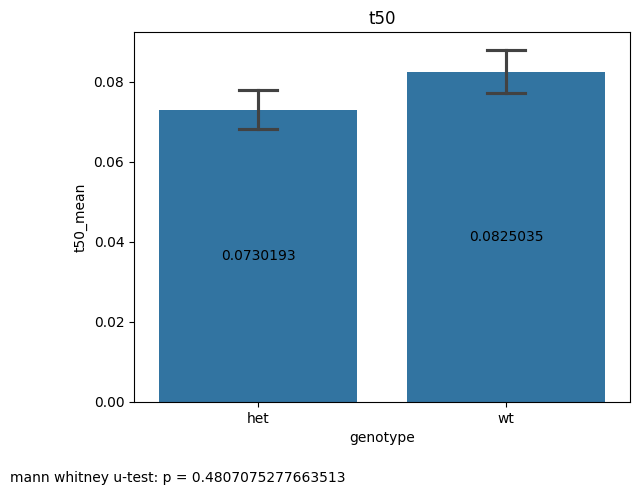

In [128]:
ax0 = sns.barplot(df, x='genotype', y='t50_mean', errorbar = 'se', capsize=.15)
ax0.bar_label(ax0.containers[0], label_type='center')
ax0.set_title('t50')
ax0.text(-1, -.02, f"mann whitney u-test: p = {stats.mannwhitneyu(w_t50_mean,h_t50_mean)[1]}")
print(stats.mannwhitneyu(w_t50_mean,h_t50_mean))

MannwhitneyuResult(statistic=46.0, pvalue=0.37038255861785274)


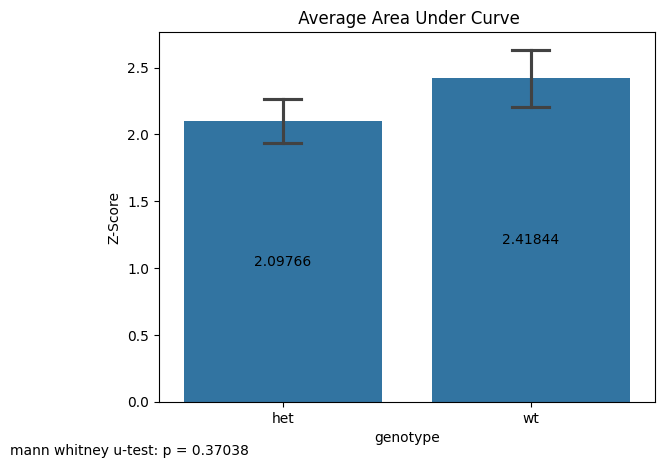

In [129]:
ax1 = sns.barplot(df, x='genotype', y='auc_mean', errorbar = 'se', capsize=.15)
ax1.bar_label(ax1.containers[0], label_type='center')
ax1.text(-1.1, -.4, f"mann whitney u-test: p = {np.round(stats.mannwhitneyu(w_auc_mean,h_auc_mean)[1], decimals=5)}")
ax1.set_ylabel('Z-Score')
ax1.set_title(' Average Area Under Curve')
print(stats.mannwhitneyu(w_auc_mean,h_auc_mean))
# 0 - 2 seconds

In [130]:
l=[]
for key in w_dict.keys():
    l.append(len(w_dict[key]['z-score']))
print(np.mean(l))

16.333333333333332


[6.60e+01 2.47e-03]


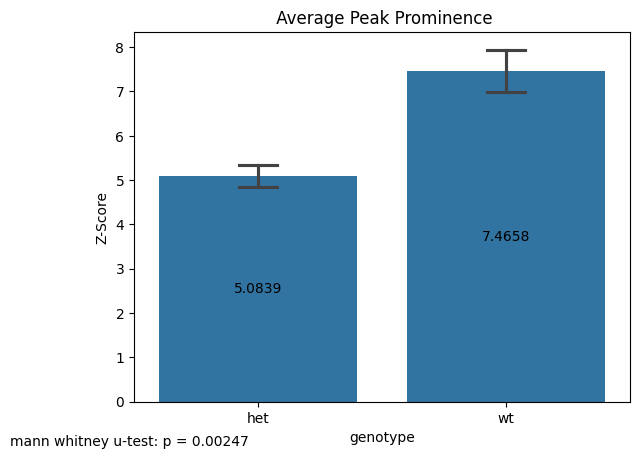

In [131]:
ax2 = sns.barplot(df, x='genotype', y='peak_prominence', errorbar = 'se', capsize=.15)
ax2.bar_label(ax2.containers[0], label_type='center')
ax2.text(-1, -1, f"mann whitney u-test: p = {np.round(stats.mannwhitneyu(w_prominence_means,h_prominence_means)[1], decimals=5)}")
ax2.set_ylabel('Z-Score')
ax2.set_title(' Average Peak Prominence')
print(np.round(stats.mannwhitneyu(w_prominence_means,h_prominence_means), decimals=5))

MannwhitneyuResult(statistic=64.0, pvalue=0.005512134923899629)


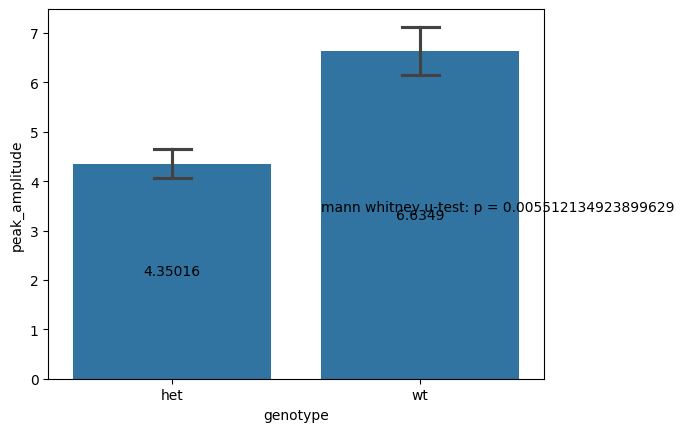

In [132]:
ax3 = sns.barplot(df, x='genotype', y='peak_amplitude', errorbar = 'se', capsize=.15)
ax3.bar_label(ax3.containers[0], label_type='center')
ax3.text(.60, 3.4, f"mann whitney u-test: p = {stats.mannwhitneyu(w_peak_amp_mean,h_peak_amp_mean)[1]}")
print(stats.mannwhitneyu(w_peak_amp_mean,h_peak_amp_mean))

In [133]:
h_mean_zscores = []
w_mean_zscores = []
for key in h_dict.keys():
    h_mean_zscores.append(np.mean(h_dict[key]['z-score'], axis=0))
for key in w_dict.keys():
    w_mean_zscores.append(np.mean(w_dict[key]['z-score'], axis=0))

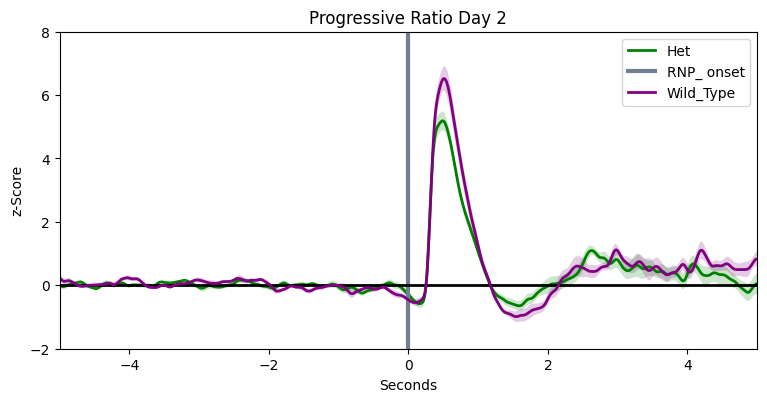

In [153]:
fig = plt.figure(figsize=(9, 14))

ax2 = fig.add_subplot(313)
p6 = ax2.plot(ts2, np.mean(h_mean_zscores, axis=0), linewidth=2, color='green', label='Het')
p7 = ax2.fill_between(h_ts1, np.mean(h_mean_zscores, axis=0)+(np.std(h_mean_zscores, axis=0)/np.sqrt(np.size(h_mean_zscores, axis=0)))
                      ,np.mean(h_mean_zscores, axis=0)-(np.std(h_mean_zscores, axis=0)/np.sqrt(np.size(h_mean_zscores, axis=0))), facecolor='green', alpha=0.2)
p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label=f'{event_type} onset')
p8 = ax2.axhline(y=0, linewidth=2, color='black')
ax2.set_ylim([-2, 8])
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title(event_type)
# ax2.scatter((w_peaks[0]-509)/101, w_peaks_y, s = 60, color="red", marker = "o")
# ax2.scatter((h_peaks[0]-509)/101, h_peaks_y, s = 60, color="red", marker = "o")
p9 = ax2.plot(ts2, np.mean(w_mean_zscores, axis=0), linewidth=2, color='purple', label='Wild_Type')
p10 = ax2.fill_between(w_ts1, np.mean(w_mean_zscores, axis=0)+(np.std(w_mean_zscores, axis=0)/np.sqrt(np.size(w_mean_zscores, axis=0)))
                      ,np.mean(w_mean_zscores, axis=0)-(np.std(w_mean_zscores, axis=0)/np.sqrt(np.size(w_mean_zscores, axis=0))), facecolor='purple', alpha=0.2)
ax2.set_title('Progressive Ratio Day 2')
# ax2.text(-6, -4, 'EN165 temporarily excluded')
# p11 = ax2.axvline(x=1.5, linewidth=3, color = 'red')
ax2.legend()

In [135]:
print(np.std(hdf['auc_mean']), np.std(wdf['auc_mean']))

0.4376315262914898 0.6125994079033266


In [136]:
hdf['auc_mean'].to_clipboard(index=False)

Curve Fitting

In [137]:
def biexponential2(t, I0, Imax, T0, k1, k2):
    y = I0 + (Imax * (1 - np.exp(-((t - T0) / k1))) * np.exp(-((t - T0) / k2)))
    y[t <= T0] = I0
    return y

In [138]:
def Gamma(t, A, alpha, beta, I0, T0):
    y = (A*((t-T0)**alpha)*np.exp(-(t-T0)/beta)) + I0
    y[t<=T0] = I0
    return y
Gamma_init = [1,1,1,1,0]

In [139]:
w_mean_zscores_trimmed=[]
for key in w_dict.keys():
    w_mean_zscores_trimmed.append(np.mean(w_dict[key]['trimmed_z-score'], axis = 0))
h_mean_zscores_trimmed=[]
for key in h_dict.keys():
    h_mean_zscores_trimmed.append(np.mean(h_dict[key]['trimmed_z-score'], axis = 0))

In [140]:
from scipy.optimize import curve_fit

In [141]:
def get_coeffs(time, zscore):
    t = np.array(time)
    alphas = []
    betas = []
    for i in range(len(zscore)):
        y = np.array(zscore[i])
        A = np.max(zscore[i])
        init = [A,1,1,0,0]
        params, covariance = curve_fit(Gamma, t, y, p0=init, maxfev = 100000)
        alphas.append(params[1])
        betas.append(params[2])
    return alphas, betas

In [142]:
# data=tdt.read_block(r"c:\Users\aak283\Fiber_Photo\Tanks\RI60 Day 8 tanks\het\EN140_RI60D8-240727-140607")


In [143]:
# wtdiff = []
# for file in glob.glob(wt_path):
#     data = tdt.read_block(file)
#     for i in range(len(data.epocs.RMG_.onset)):
#         if (data.epocs.RMG_.onset[i] - data.epocs.RNP_.onset[i]) >=5:
#             print(data.epocs.RMG_.onset[i] - data.epocs.RNP_.onset[i])
#             # wtdiff.append(data.epocs.RMG_.onset[i] - data.epocs.RNP_.onset[i])


In [144]:
# htdiff = []
# for file in glob.glob(het_path):
#     data = tdt.read_block(file)
#     for i in range(len(data.epocs.RMG_.onset)):
#         # print(data.epocs.RNP_.onset[i], data.epocs.RMG_.onset[i])
#         if (data.epocs.RMG_.onset[i] - data.epocs.RNP_.onset[i]) <=5:
#             htdiff.append(data.epocs.RMG_.onset[i] - data.epocs.RNP_.onset[i])

In [145]:
# print(np.mean(wtdiff))

In [146]:
# print(np.mean(htdiff))

C:\Users\User\AppData\Local\Temp\ipykernel_21212\3297585235.py:2: RuntimeWarning: invalid value encountered in power
  y = (A*((t-T0)**alpha)*np.exp(-(t-T0)/beta)) + I0
C:\Users\User\AppData\Local\Temp\ipykernel_21212\3339676606.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


603.5949819452454 1.9815986786093385 0.14902566030997194 -0.8239748262554024 0.20888440784584808
155.43895657551215 1.3351027160793996 0.1740449691118157 -0.5111917699409836 0.24134173645617513


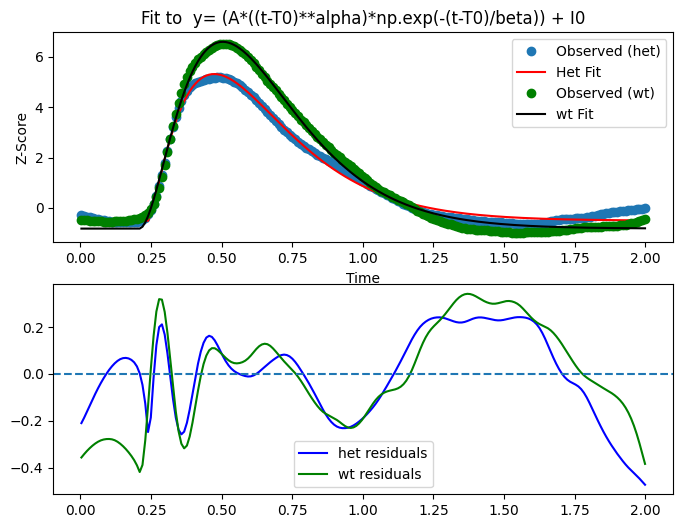

In [147]:
t = np.array(trimmed_ts)
hy = np.array(np.mean(h_mean_zscores_trimmed, axis = 0))
hamp = np.max(hy)
h_Gamma_init = [hamp,1,1,0,0]

wy = np.array(np.mean(w_mean_zscores_trimmed, axis = 0))
wamp = np.max(wy)
w_Gamma_init = [wamp,1,1,0,0]

hparams, covariance = curve_fit(Gamma, t, hy, p0=h_Gamma_init, maxfev = 100000)
wparams, covariance = curve_fit(Gamma, t, wy, p0=w_Gamma_init, maxfev = 100000)

hfitted_y = Gamma(t, *hparams)
wfitted_y = Gamma(t, *wparams)

fig, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].set_title(r'Fit to  y= (A*((t-T0)**alpha)*np.exp(-(t-T0)/beta)) + I0')
axs[0].plot(t, hy, 'o', label='Observed (het)')
axs[0].plot(t, hfitted_y, 'r-', label='Het Fit')
axs[0].plot(t, wy, 'o', label = 'Observed (wt)', color = 'green')
axs[0].plot(t, wfitted_y, label = 'wt Fit', color = 'black')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Z-Score')
axs[0].legend()

axs[1].plot(t, hfitted_y-hy, color = 'blue', label = 'het residuals')
axs[1].plot(t, wfitted_y-wy, color = 'green', label = 'wt residuals')
axs[1].axhline(0, ls='--')
axs[1].legend()
fig.show()
print(*wparams)
print(*hparams)

In [148]:
het_alphas, het_betas = get_coeffs(trimmed_ts, h_mean_zscores_trimmed)
wt_alphas, wt_betas = get_coeffs(trimmed_ts, w_mean_zscores_trimmed)

C:\Users\User\AppData\Local\Temp\ipykernel_21212\3297585235.py:2: RuntimeWarning: invalid value encountered in power
  y = (A*((t-T0)**alpha)*np.exp(-(t-T0)/beta)) + I0


In [156]:
het_betas

[0.21266170883804034,
 0.15593091267196363,
 0.14811437635421482,
 0.15713333928301282,
 0.14364542795369986,
 0.12288740276482585,
 0.16109678150493184,
 0.20822832391259566]

In [155]:
stats.mannwhitneyu(np.array(het_alphas), np.array(wt_alphas))

MannwhitneyuResult(statistic=22.0, pvalue=0.1995886466474702)

In [151]:
np.array(het_betas)

array([0.21266171, 0.15593091, 0.14811438, 0.15713334, 0.14364543,
       0.1228874 , 0.16109678, 0.20822832])

In [152]:
dfcopy = pd.DataFrame(het_betas)
dfcopy.to_clipboard(index = False)